In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import time
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
import scipy as sp

In [2]:
corona_df=pd.read_csv("/kaggle/input/covid19-global-forecasting-week-2/train.csv").fillna(np.nan)
countries_df = pd.read_csv("../input/population-by-country-2020/population_by_country_2020.csv").fillna(np.nan)
df_temperature = pd.read_csv("../input/covid19-global-weather-data/temperature_dataframe.csv").fillna(np.nan)

In [3]:
corona_df.head()

,Id,Province_State,Country_Region,Date,ConfirmedCases,Fatalities
0,1,NaN,Afghanistan,2020-01-22,0.0,0.0
1,2,NaN,Afghanistan,2020-01-23,0.0,0.0
2,3,NaN,Afghanistan,2020-01-24,0.0,0.0
3,4,NaN,Afghanistan,2020-01-25,0.0,0.0
4,5,NaN,Afghanistan,2020-01-26,0.0,0.0


In [4]:
countries_df.head()

,Country (or dependency),Population (2020),Yearly Change,Net Change,Density (P/Km²),Land Area (Km²),Migrants (net),Fert. Rate,Med. Age,Urban Pop %,World Share
0,China,1439323776,0.39%,5540090,153,9388211,-348399.0,1.7,38,61%,18.47%
1,India,1380004385,0.99%,13586631,464,2973190,-532687.0,2.2,28,35%,17.70%
2,United States,331002651,0.59%,1937734,36,9147420,954806.0,1.8,38,83%,4.25%
3,Indonesia,273523615,1.07%,2898047,151,1811570,-98955.0,2.3,30,56%,3.51%
4,Pakistan,220892340,2.00%,4327022,287,770880,-233379.0,3.6,23,35%,2.83%


In [5]:
df_temperature.head()

,Unnamed: 0,id,province,country,lat,long,date,cases,fatalities,capital,humidity,sunHour,tempC,windspeedKmph
0,0,1,NaN,Afghanistan,33.0,65.0,2020-01-22,0.0,0.0,Kabul,65.0,8.7,-1.0,8.0
1,1,2,NaN,Afghanistan,33.0,65.0,2020-01-23,0.0,0.0,Kabul,59.0,8.7,-3.0,8.0
2,2,3,NaN,Afghanistan,33.0,65.0,2020-01-24,0.0,0.0,Kabul,71.0,7.1,0.0,7.0
3,3,4,NaN,Afghanistan,33.0,65.0,2020-01-25,0.0,0.0,Kabul,79.0,8.7,0.0,7.0
4,4,5,NaN,Afghanistan,33.0,65.0,2020-01-26,0.0,0.0,Kabul,64.0,8.7,-1.0,8.0


In [6]:
corona_df.rename(columns={'Date': 'date', 
                     'Province_State':'state',
                     'Country_Region':'country',
                     'ConfirmedCases': 'confirmed',
                     'Fatalities':'deaths',
                    }, inplace=True)
corona_df["date"] = pd.to_datetime(corona_df['date'])

countries_df.rename(columns={'Country (or dependency)': 'country',
                             'Population (2020)' : 'population',
                             'Density (P/Km²)' : 'density',
                             'Fert. Rate' : 'fertility',
                             'Med. Age' : "age",
                             'Urban Pop %' : 'urban_percentage'}, inplace=True)
countries_df['country'] = countries_df['country'].replace('United States', 'US')
countries_df = countries_df[["country", "population", "density", "fertility", "age", "urban_percentage"]]

df_temperature.rename(columns={'province': 'state'}, inplace=True)
df_temperature['country'] = df_temperature['country'].replace('USA', 'US')
df_temperature['country'] = df_temperature['country'].replace('UK', 'United Kingdom')
df_temperature = df_temperature[["country", "state", "date", "humidity", "sunHour", "tempC", "windspeedKmph"]].reset_index()
df_temperature["date"] = pd.to_datetime(df_temperature['date'])

In [7]:
corona_df = pd.merge(corona_df, countries_df, on='country')
corona_df = corona_df.merge(df_temperature, on=['country','date', 'state'], how='inner')

In [8]:
corona_df.head()

,Id,state,country,date,confirmed,deaths,population,density,fertility,age,urban_percentage,index,humidity,sunHour,tempC,windspeedKmph
0,1,NaN,Afghanistan,2020-01-22,0.0,0.0,38928346,60,4.6,18,25%,0,65.0,8.7,-1.0,8.0
1,2,NaN,Afghanistan,2020-01-23,0.0,0.0,38928346,60,4.6,18,25%,1,59.0,8.7,-3.0,8.0
2,3,NaN,Afghanistan,2020-01-24,0.0,0.0,38928346,60,4.6,18,25%,2,71.0,7.1,0.0,7.0
3,4,NaN,Afghanistan,2020-01-25,0.0,0.0,38928346,60,4.6,18,25%,3,79.0,8.7,0.0,7.0
4,5,NaN,Afghanistan,2020-01-26,0.0,0.0,38928346,60,4.6,18,25%,4,64.0,8.7,-1.0,8.0


In [9]:
corona_df=corona_df.replace("N.A.",np.nan)
corona_df.urban_percentage=[float(x.strip('%'))/100 for x in corona_df.urban_percentage.astype(str)]
corona_df.drop(["Id","state"],axis=1,inplace=True)
corona_df.ix[:,6:8]=corona_df.ix[:,2:].select_dtypes(include='object').astype("float")
corona_df['day'] = corona_df['date'].dt.day
corona_df['month'] = corona_df['date'].dt.month
corona_df['year'] = corona_df['date'].dt.year

In [10]:
#indian data
corona_df_IND=corona_df[corona_df.country=="India"].reset_index(drop=True).drop(["country","index","population","density","fertility","age","urban_percentage"],axis=1)

In [11]:
corona_df_IND.describe()

,confirmed,deaths,humidity,sunHour,tempC,windspeedKmph,day,month,year
count,60.000000,60.000000,60.0000,60.000000,60.000000,60.000000,60.000000,60.000000,60.0
mean,32.950000,0.483333,44.3000,10.291667,26.533333,10.200000,15.516667,2.183333,2020.0
std,65.000241,1.157022,10.3879,1.698583,3.828823,4.309233,8.757547,0.700887,0.0
min,0.000000,0.000000,21.0000,3.900000,19.000000,5.000000,1.000000,1.000000,2020.0
25%,3.000000,0.000000,37.0000,9.750000,23.000000,7.000000,8.000000,2.000000,2020.0
50%,3.000000,0.000000,44.0000,11.000000,27.000000,9.000000,15.500000,2.000000,2020.0
75%,31.750000,0.000000,50.0000,11.600000,29.000000,12.000000,23.000000,3.000000,2020.0
max,330.000000,5.000000,70.0000,11.600000,35.000000,21.000000,31.000000,3.000000,2020.0


In [12]:
y_c = (corona_df_IND['confirmed'].astype(int))
y_d = (corona_df_IND['deaths'].astype(int))
x=corona_df_IND.drop(["confirmed","deaths","date"], axis=1)

In [13]:
import xgboost
from sklearn.model_selection import cross_val_score,KFold
from sklearn.model_selection import  train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model

In [14]:
def reg_mod(X_train, Y_train, X_test):
    # Create linear regression object
    regr = linear_model.LinearRegression()
    # Train the model using the training sets
    regr.fit(X_train, Y_train)
    # Make predictions using the testing set
    y_pred = regr.predict(X_test)
    return regr, y_pred

In [15]:
model,y_pred=reg_mod(x.head(50),y_c.head(50),x.tail(10))

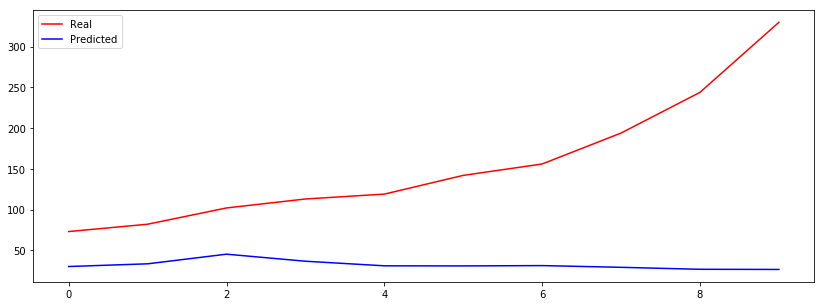

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
plt.figure(figsize=(14,5))
plt.plot(y_c.tail(10).reset_index(drop=True), color = 'red', label = 'Real')
plt.plot(y_pred, color = 'blue', label = 'Predicted')
# plt.title('Google Stock Price Prediction')
plt.legend()
plt.show()